In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd

%matplotlib inline

Let's revisit Schrodinger's equation for the harmonic oscillator. The equation to solve is

$$-\frac{\hbar^2}{2m} \frac{d^2\psi}{dx^2} + \frac{1}{2}m\omega^2x^2\psi = E\psi.$$

We can rewrite to make the code more obvious:

$$\frac{d^2\psi}{dx^2} = -\frac{2m}{\hbar^2}\left(E - \frac{1}{2}m\omega^2x^2\right)\psi.$$

In [47]:
def qho(y, x, E, m=1.0, hbar=1.0, omega=1.0):
    """RHS for a quantum harmonic oscillator
    
    Parameters:
    -----------
    y : iterable of floats
        contains $\psi(x)$ and $\psi'(x)$
    x : float
        the position at which we're evaluating the equation
    E : float
        Energy of the quantum state
    m : float, optional
        mass; defaults to 1
    hbar : float, optional
           Planck's constant/2pi; defaults to 1
    omega : float, optional
            frequency of the oscillator; defaults to 1
    
    Returns:
    --------
    float : the right hand side of the time independent schrodinger equation for the harmonic oscillator
    $$\frac{d^2\psi}{dx^2} = -\frac{2m}{\hbar^2}\left(E - \frac{1}{2}m\omega^2x^2\right)\psi.$$
    """
    psi, psiprime = y
    psidoubleprime = -(2*m/hbar**2)*(E-m*omega**2*x**2/2)*psi
    
    return np.array([psiprime, psidoubleprime])

Choosing initial conditions for this is difficult, because both $\psi$ and $\psi'$ go asymptotically to zero as $|x|$ gets large. Instead, we will integrate from the middle outward. This requires some knowlege of the physical system (symmetric potentials yield symmetric wave functions, for example) and isn't always possible. In this case, though, it works wonders.

In [35]:
def mirror_result(domain, result, even=True):
    """mirror a result across x=0
    
    This allows us to integrate from the center outward on the positive side, and
    simply mirror the result on the negative side.
    
    Parameters:
    -----------
    domain : numpy array
             the domain of integration
    result : numpy array
             output from odeint
    even : boolean
           True if the result is an even function
           This could probably be refactored out if we check to see if the initial value/slope are consistent with
           even/odd functions.
           
    Returns:
    --------
    two numpy arrays with the extended domain and extended result.
    
    """
    negdom = -np.flip(domain, 0)
    if even:
        negres = np.flip(result, 0)
    else:
        negres = -np.flip(result, 0)
    fulldom = np.concatenate([negdom, domain])
    fullres = np.concatenate([negres, result])
    
    return fulldom, fullres

With that in hand, solving the equation is easy if we know the energies. We get non-normalized solutions, but that's okay -- we can apply normalization after the fact.

The half solution looks like this:

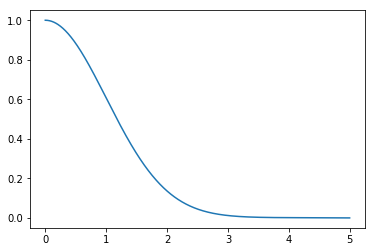

In [45]:
domain = np.linspace(0,5,1000)
y0 = (1.0, 0.0)
result = odeint(qho, y0, domain, args=(0.5,))

plt.plot(domain, result[:,0])

... and when mirrored, we get:

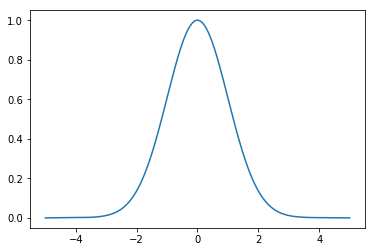

In [46]:
fulldom, fullres = mirror_result(domain, result)

plt.plot(fulldom, fullres[:,0])

Additional wave functions come from incrementing the energy.

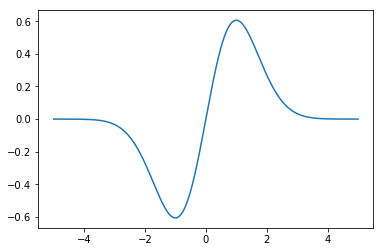

In [42]:
y0 = (0.0, 1.0)
result = odeint(qho, y0, domain, args=(1.5,))
fulldom, fullres = mirror_result(domain, result, even=False)
plt.plot(fulldom, fullres[:,0])

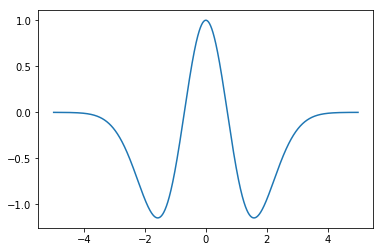

In [43]:
y0 = (1.0, 0.0)
result = odeint(qho, y0, domain, args=(2.5,))
fulldom, fullres = mirror_result(domain, result, even=True)
plt.plot(fulldom, fullres[:,0])

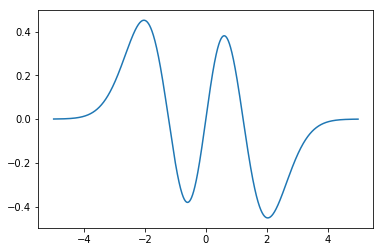

In [44]:
y0 = (0.0, 1.0)
result = odeint(qho, y0, domain, args=(3.5,))
fulldom, fullres = mirror_result(domain, result, even=False)
plt.plot(fulldom, fullres[:,0])

What if we don't know the energy?

In [48]:
from scipy.optimize import bisect

In [49]:
help(bisect)

Help on function bisect in module scipy.optimize.zeros:

bisect(f, a, b, args=(), xtol=2e-12, rtol=8.8817841970012523e-16, maxiter=100, full_output=False, disp=True)
    Find root of a function within an interval.
    
    Basic bisection routine to find a zero of the function `f` between the
    arguments `a` and `b`. `f(a)` and `f(b)` cannot have the same signs.
    Slow but sure.
    
    Parameters
    ----------
    f : function
        Python function returning a number.  `f` must be continuous, and
        f(a) and f(b) must have opposite signs.
    a : number
        One end of the bracketing interval [a,b].
    b : number
        The other end of the bracketing interval [a,b].
    xtol : number, optional
        The computed root ``x0`` will satisfy ``np.allclose(x, x0,
        atol=xtol, rtol=rtol)``, where ``x`` is the exact root. The
        parameter must be nonnegative.
    rtol : number, optional
        The computed root ``x0`` will satisfy ``np.allclose(x, x0,
        